In this workbook,
I have build regression models using DT, LR and xgboost 

The goal is to predict the price of the diamond using some features describing the diamond quality for ex, color, cut etc.

In [ ]:
### This a new change that I have made in branch shishir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [ ]:
## Load data
data = pd.read_excel("qa-0702.xls", sheet_name='Raw Data', skiprows=[0,1])

In [ ]:
## Filter data with for which price is available
df = data.iloc[0:6000,:]
df_pred = data.iloc[6000:,:]
# Rename Carat weight
df.rename(columns={'Carat Weight': 'Carat_Weight'}, inplace=True)
df_pred.rename(columns={'Carat Weight': 'Carat_Weight'}, inplace=True)
df.tail(1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ID,Carat_Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
5999,6000,2.19,Ideal,E,VS1,EX,EX,GIA,30507.0


In [ ]:
# data Summary 
nrows, ncols = df.shape
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            6000 non-null   int64  
 1   Carat_Weight  6000 non-null   float64
 2   Cut           6000 non-null   object 
 3   Color         6000 non-null   object 
 4   Clarity       6000 non-null   object 
 5   Polish        6000 non-null   object 
 6   Symmetry      6000 non-null   object 
 7   Report        6000 non-null   object 
 8   Price         6000 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 422.0+ KB
None


# EDA 

**Numerical data** 

Text(0, 0.5, 'Price')

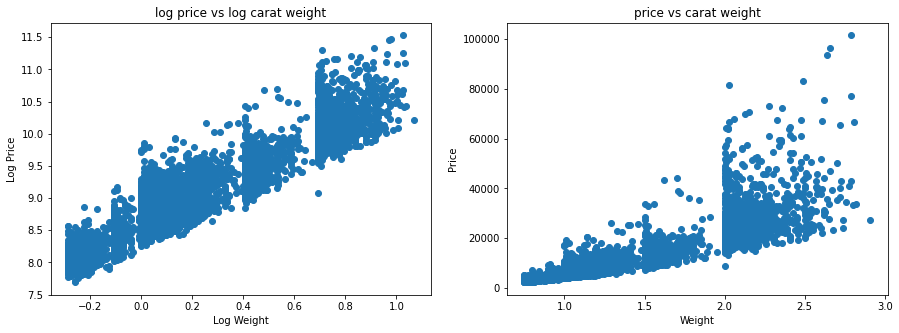

In [ ]:
# Scatter plot of Price vs Weight
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.scatter(np.log(df.Carat_Weight), np.log(df.Price))
ax1.set_title("log price vs log carat weight")
ax1.set_xlabel("Log Weight")
ax1.set_ylabel("Log Price")
ax2.scatter(df.Carat_Weight,df.Price)
ax2.set_title("price vs carat weight")
ax2.set_xlabel("Weight")
ax2.set_ylabel("Price")

**Categorical Data**

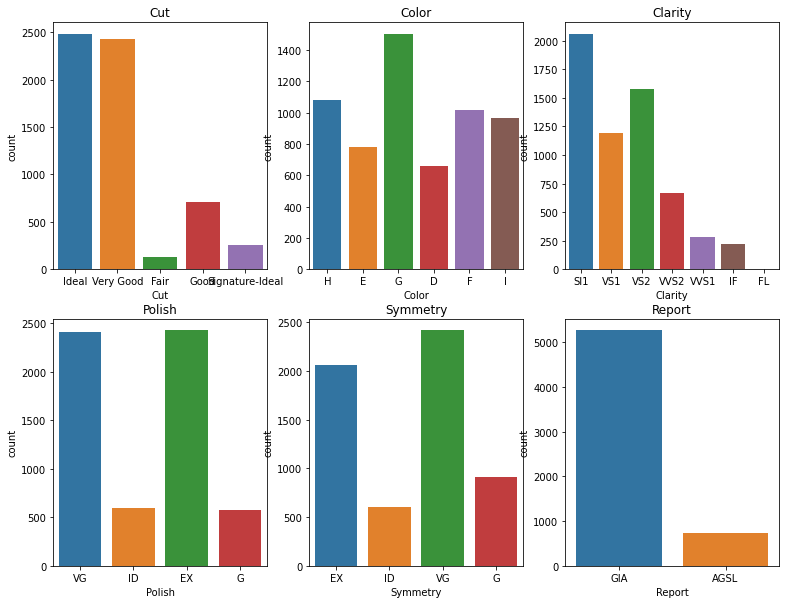

In [ ]:
## frequncy distrbution of Categories
fig = plt.figure(figsize=(13,10))
# Cut 
ax1 = fig.add_subplot(2,3,1)
sns.countplot(df.Cut, ax=ax1)
ax1.set_title("Cut")
# Color
ax2 = fig.add_subplot(2,3,2)
sns.countplot(df.Color, ax=ax2)
ax2.set_title("Color")
# Clarity
ax3 = fig.add_subplot(2,3,3)
sns.countplot(df.Clarity, ax=ax3)
ax3.set_title("Clarity")
# Polish 
ax4 = fig.add_subplot(2,3,4)
sns.countplot(df.Polish, ax=ax4)
ax4.set_title("Polish")
# Symmetry
ax5 = fig.add_subplot(2,3,5)
sns.countplot(df.Symmetry, ax=ax5)
ax5.set_title("Symmetry")
# Report
ax6 = fig.add_subplot(2,3,6)
sns.countplot(df.Report, ax=ax6)
ax6.set_title("Report")

plt.show()

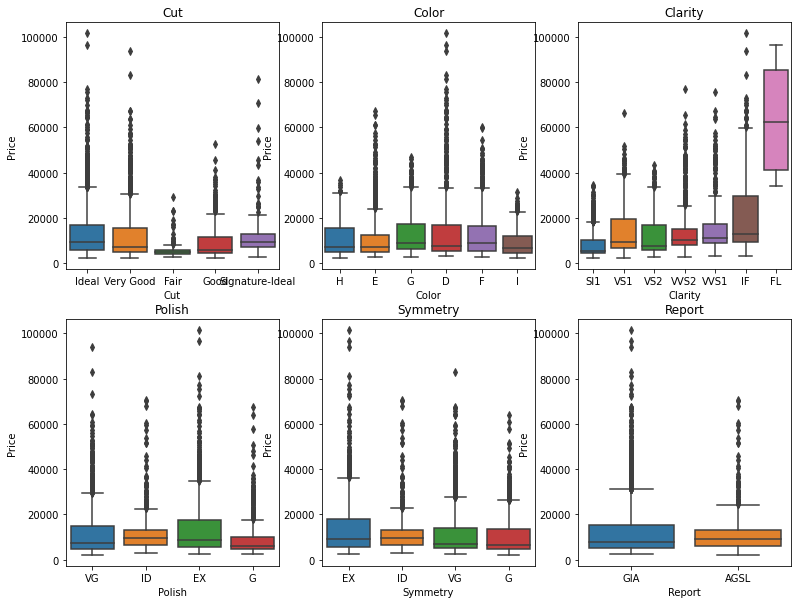

In [ ]:
## Replatioship between all the categorical variables and Price
# Cut
fig2 = plt.figure(figsize=(13,10))
ax7 = fig2.add_subplot(2,3,1)
sns.boxplot(data=df, x='Cut', y = 'Price', ax=ax7)
ax7.set_title("Cut")
# Color
ax8 = fig2.add_subplot(2,3,2)
sns.boxplot(data=df, x='Color', y = 'Price', ax=ax8)
ax8.set_title("Color")
# Clarity
ax9 = fig2.add_subplot(2,3,3)
sns.boxplot(data=df, x='Clarity', y = 'Price', ax=ax9)
ax9.set_title("Clarity")
# Polish 
ax0 = fig2.add_subplot(2,3,4)
sns.boxplot(data=df, x='Polish', y = 'Price', ax=ax0)
ax0.set_title("Polish")
# Symmetry
ax11 = fig2.add_subplot(2,3,5)
sns.boxplot(data=df, x='Symmetry', y = 'Price', ax=ax11)
ax11.set_title("Symmetry")
# Report
ax12 = fig2.add_subplot(2,3,6)
sns.boxplot(data=df, x='Report', y = 'Price', ax=ax12)
ax12.set_title("Report")
plt.show()

**Split the dataset in Train and Test**

In [ ]:
## split the data in training and test set
X = df.drop(columns=['ID','Price'], axis=1)
Y = df.loc[:, 'Price']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [ ]:
X_train.columns

Index(['Carat_Weight', 'Cut', 'Color', 'Clarity', 'Polish', 'Symmetry',
       'Report'],
      dtype='object')

**Create Custom Transformers for Data Preprocessing**

In [ ]:
ordinal_feature = ['Cut', 'Color', 'Clarity','Polish','Symmetry']
Num_feature = ['Carat_Weight']
## Feature Engineering steps on X
# - Convert the Carat_Weight to log 
# - Ordinal encoding for the ordinal categorical variables
# - Convert Report column to number 
# - Update 'Polish' and 'Symmetry' columns based on Report column

## Create the transformers needed to be applied on the features 
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder
from sklearn.base import TransformerMixin, clone
from functools import reduce
##1)  Create custom transformer to extract the columns ##################################
class ColumnExtractor(TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    def fit(self, X, y=None):
        # stateless transformer
        return self
    def transform(self, X):
        # assumes X is a DataFrame
        Xcols = X[self.cols]
        return Xcols
##2)  Custom Transformer to create log for numerical variable ########################
class LogTransformer(TransformerMixin):
    def fit(self, X, y=None):
        # stateless transformer
        return self
    def transform(self, X):
        # assumes X is a DataFrame
        Xlog = np.log(X).round(3)
        return Xlog
# 3) Ordinal variables encoding using Tranformer - OrdinalEncoder ###########################
# Create list of categories based on ranking
cut = ['Fair','Good','Very Good','Ideal','Signature-Ideal']
Color = ['I','H','G','F','E','D']
Clarity = ['SI1', 'VS2','VS1','VVS2','VVS1','IF','FL']
Pol = ['G', 'VG', 'EX', 'ID']
Sym = ['G', 'VG', 'EX', 'ID']
All_cat = [cut, Color, Clarity, Pol, Sym]
# create object for ordinal encoder
# 4) Customer transformer for the report column update
class Reportcolumn(TransformerMixin):
    def fit(self, X, y=None):
        # stateless transformer
        return self
    def transform(self, X):
        # assumes X is a DataFrame
        Xupdate = pd.DataFrame(np.where(X=='GIA', 1, 0.75),index=X.index, columns=X.columns)
        return Xupdate
# 4) Transformer to unionize the transformed featured
class DFFeatunion(TransformerMixin):
    # FeatureUnion
    def __init__(self, transformer_list):
        self.transformer_list = transformer_list
    def fit(self, X, y=None):
        for (name, t) in self.transformer_list:
            t.fit(X, y)
        return self
    def transform(self, X):
        # assumes X is a DataFrame
        Xts = [t.transform(X) for _, t in self.transformer_list]
        Xunion = reduce(lambda X1, X2: pd.merge(X1, X2, left_index=True, right_index=True), Xts)
        return Xunion
# 5) ordinal Encoder - Return dataframe
class DFordinalencoder(TransformerMixin):
# return a dataframe
    def __init__(self, category_list):
        self.category_list = category_list
    def fit(self, X, y=None):
        self.oe = OrdinalEncoder(self.category_list)     
        self.oe.fit(X)  
        return self
    def transform(self, X):
        # assumes X is a DataFrame
        X_oe = self.oe.transform(X)
        X_df = pd.DataFrame(X_oe, index=X.index, columns=X.columns)
        return X_df

# 6) Feature Union for Dataframe

class DFConvert(TransformerMixin):
    def __init__(self, cols, ind):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # assumes X is a DataFrame
        X_df = pd.DataFrame(X, index=ind, columns=cols)
        return X_df



class DataFrameFeatureUnion(TransformerMixin):
    def __init__(self, list_of_transformers):
        self.list_of_transformers = list_of_transformers       
    def transform(self, X, **transformparamn):               
        concatted = pd.concat([transformer.transform(X)for transformer in self.fitted_transformers_], axis=1).copy()
        return concatted
    def fit(self, X, y=None, **fitparams):  
      self.fitted_transformers_ = []
      for name, transformer in self.list_of_transformers:
          fitted_trans = transformer.fit(X, y=None, **fitparams)
          self.fitted_transformers_.append(fitted_trans)
      return self


**Preprocessing Pipeline**

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OrdinalEncoder as os
## DFfreatureUnion is merging all the columns
# Column etxracter - extract the given columns for the pipeline
pipeline = Pipeline([                    
    ('features', DataFrameFeatureUnion([
    ('numerics', Pipeline([
            ('extract', ColumnExtractor(Num_feature)),
            ('log', LogTransformer())
        ])),
    ('ordinal', Pipeline([
            ('extract', ColumnExtractor(ordinal_feature)),
            ('log', DFordinalencoder(All_cat))
        ])),
    ('report', Pipeline([
            ('extract', ColumnExtractor(['Report'])),
            ('reportencode', Reportcolumn())]))
    ]))
])

In [ ]:
############################### Fit and Transform the data using pipline
pipeline.fit(X_train)
X_train2 = pipeline.transform(X_train)

In [ ]:
X_train2.head(2)

,Carat_Weight,Cut,Color,Clarity,Polish,Symmetry,Report
2846,0.875,2.0,5.0,4.0,0.0,0.0,1.0
5926,0.010,3.0,2.0,2.0,2.0,2.0,1.0


In [ ]:
X_train2.shape

(4500, 7)

 Update the Polish and Syymtery Columns based on Report and drop 'report'

In [ ]:
X_train2['Polish'] = X_train2['Polish'] * X_train2['Report']
X_train2['Symmetry'] = X_train2['Symmetry'] * X_train2['Report']

In [ ]:
# Drop Report
X_train2.drop(columns=['Report'], axis=1, inplace=True)

In [ ]:
X_train2.head(10)

,Carat_Weight,Cut,Color,Clarity,Polish,Symmetry
2846,0.875,2.0,5.0,4.0,0.00,0.00
5926,0.010,3.0,2.0,2.0,2.00,2.00
2796,-0.236,3.0,4.0,0.0,2.00,2.00
1195,0.191,4.0,4.0,3.0,2.25,2.25
1586,0.199,3.0,2.0,2.0,2.25,2.25
2290,0.775,2.0,0.0,4.0,2.00,1.00
2377,0.020,1.0,1.0,0.0,1.00,1.00
2381,0.068,4.0,2.0,0.0,2.25,2.25
4242,0.438,3.0,3.0,3.0,2.00,2.00
4997,-0.105,3.0,1.0,2.0,1.00,1.00


**Covert Y_train (Price) Log**

In [ ]:
y_train2 = np.log(y_train).round(3)
y_train2.head(4)

2846    11.064
5926     8.890
2796     7.988
1195     9.578
Name: Price, dtype: float64

In [ ]:
y_train2.shape

(4500,)

# Train Decision Tree, Linear Regression and xgBoost models

In [ ]:
## Train on decision tree 
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(random_state=0)
reg_tree.fit(X_train2,y_train2)

## Train on Linear Regression 
from sklearn.linear_model import LinearRegression
reg_linear = LinearRegression()
reg_linear.fit(X_train2,y_train2)

## Train on xgBost
from xgboost import XGBRegressor
reg_xg = XGBRegressor()
reg_xg.fit(X_train2,y_train2)

[21:33:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

# Check Accuracy of all the models by making prediction on the Test set

In [ ]:
# Preprocess X_test
X_test2 = pipeline.transform(X_test)

In [ ]:
X_test2['Polish'] = X_test2['Polish'] * X_test2['Report']
X_test2['Symmetry'] = X_test2['Symmetry'] * X_test2['Report']

In [ ]:
X_test2.drop(columns=['Report'], axis=1, inplace=True)
X_test2.head()

,Carat_Weight,Cut,Color,Clarity,Polish,Symmetry
4448,0.131,2.0,3.0,0.0,1.0,1.0
3168,0.030,3.0,3.0,0.0,1.0,1.0
5022,0.058,4.0,2.0,2.0,2.0,2.0
4691,0.049,3.0,1.0,1.0,1.0,1.0
596,0.113,3.0,2.0,2.0,2.0,2.0


**Make Prediction on X Test and Calculate the Accuracy**

In [ ]:
########################## Prediction ####################################
#1) Decison Tree regressor
y_predit1= reg_tree.predict(X_test2).round(decimals=3)
## Exponentiate Y_predict
y_pred_price1 = np.exp(y_predit1).round(decimals=3)

#2) Linear regression 
y_predit2= reg_linear.predict(X_test2).round(decimals=3)
## Exponentiate Y_predict
y_pred_price2 = np.exp(y_predit2).round(decimals=3)

#3) xgboost regressor
y_predit3= reg_xg.predict(X_test2).round(decimals=3)
## Exponentiate Y_predict
y_pred_price3 = np.exp(y_predit3).round(decimals=3)

################################## Accuracy Calculation ######################
from sklearn.metrics import mean_squared_error, r2_score
#1) Decison Tree regressor
print(f"Decision Tree Model-> RMSE : {np.sqrt(mean_squared_error(y_test,y_pred_price1)).round(4)}")
print(f"Decision Tree Model-> R Square: {r2_score(y_test,y_pred_price1).round(4)}")

#1) Linear Regression
print(f"\nLinear Regression Model-> RMSE : {np.sqrt(mean_squared_error(y_test,y_pred_price2)).round(4)}")
print(f"Linear Regression Model->R Square: {r2_score(y_test,y_pred_price2).round(4)}")

#1) xgBoost
print(f"\nxgBoost Model-> RMSE : {np.sqrt(mean_squared_error(y_test,y_pred_price3)).round(4)}")
print(f"xgBoost Model-> R Square: {r2_score(y_test,y_pred_price3).round(4)}")


Decision Tree Model-> RMSE : 1641.5908
Decision Tree Model-> R Square: 0.9723

Linear Regression Model-> RMSE : 2023.6071
Linear Regression Model->R Square: 0.9578

xgBoost Model-> RMSE : 1175.2531
xgBoost Model-> R Square: 0.9858


# Based on th model performance - using xgBoost for final Prediction

In [ ]:
df_pred.head()

,ID,Carat_Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
6000,6001,2.18,Very Good,I,SI1,EX,EX,GIA,NaN
6001,6002,2.32,Ideal,E,VVS2,VG,EX,GIA,NaN
6002,6003,0.77,Good,F,VS1,VG,G,GIA,NaN
6003,6004,2.01,Very Good,G,VS2,EX,EX,GIA,NaN
6004,6005,1.39,Very Good,E,VVS2,VG,EX,GIA,NaN


In [ ]:
X_prediction = df_pred.drop(columns=['ID','Price'])

In [ ]:
## Traform X_prediction using pipepline and preprocessing steps

In [ ]:
X_prediction2 = pipeline.transform(X_prediction)

In [ ]:
X_prediction2['Polish'] = X_prediction2['Polish'] * X_prediction2['Report']
X_prediction2['Symmetry'] = X_prediction2['Symmetry'] * X_prediction2['Report']

In [ ]:
X_prediction2.drop(columns=['Report'], axis=1, inplace=True)
X_prediction2.head()

,Carat_Weight,Cut,Color,Clarity,Polish,Symmetry
6000,0.779,2.0,0.0,0.0,2.0,2.0
6001,0.842,3.0,4.0,3.0,1.0,2.0
6002,-0.261,1.0,3.0,2.0,1.0,0.0
6003,0.698,2.0,2.0,1.0,2.0,2.0
6004,0.329,2.0,4.0,3.0,1.0,2.0


In [ ]:
## Fit in the xgboost model for predictions
y_final= reg_xg.predict(X_prediction2).round(decimals=3)
## Exponentiate Y_predict
y_Final_Price =  np.exp(y_final).round(decimals=3)

In [ ]:
y_Final_Price

array([17292.02 , 46397.453,  3105.718, ...,  9181.997,  7654.124,
        2849.788], dtype=float32)

In [ ]:
X_prediction2.shape

(3142, 6)

In [ ]:
## Update the price in dataframe an save in csv
df_pred['Price'] = y_Final_Price.round(2)

In [ ]:
df_pred.head()

,ID,Carat_Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
6000,6001,2.18,Very Good,I,SI1,EX,EX,GIA,17292.019531
6001,6002,2.32,Ideal,E,VVS2,VG,EX,GIA,46397.460938
6002,6003,0.77,Good,F,VS1,VG,G,GIA,3105.719971
6003,6004,2.01,Very Good,G,VS2,EX,EX,GIA,24661.529297
6004,6005,1.39,Very Good,E,VVS2,VG,EX,GIA,14072.809570
